In [1]:
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt

The eight queens puzzle is the problem of placing eight chess queens on an 8×8 chessboard so that no two queens threaten each other thus, a solution requires that no two queens share the same row, column, or diagonal.<br><br>
There are only 92 such solution out of 40320 (8!) possible configuration.<br>
One such solution that i am considering here is<br>
[ 3, 6, 2, 7, 1, 4, 0, 5]

![8%20Queen.PNG](attachment:8%20Queen.PNG "8 Queen Board")
<br><br>

I am implementing variuos cost function and crossover function<br>
**Variables of Genetic Algorithms :**
- Target configuration
- Population size
- Initial population
- Fitness of the population
- Selection probaplity
- Off-spring population
- Mutation rate

<br><br>
**Operation in Genetic Algorithm**
 - Get initial population
 - Compute fitness
    - Different cost functions
       - Position wise match score (# of matching number in population element and target)
       - Squared distance
       - Number of queen attacks
 - Selection 
 - Crossover
      - Different crossover
         - Select random slice from first parent and remaining from other parent
         - Fixed slice points and interchaging slices of parent (results in more that one off-springs)<br>
             eg: (XXX|XX|XXX + YYY|YY|YYY) => XXX|YY|XXX & YYY|XX|YYY  &  XXX|XX|YYY etc.
 - Mutation

**Variables to keep track**
 - number of generations
 - best member in each generation
 - score for each generation
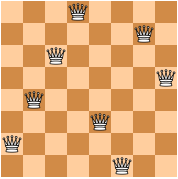

In [8]:
class GeneticAlgorithm:
    n_queen = 8
    def __init__(self,pop_size,target,n_queen=8):
        GeneticAlgorithm.n_queen = n_queen
        GeneticAlgorithm.target = target
        self.pop_size = pop_size
        self.population = []
        self.fitness = []
        self.prob = []
        self.new_population = []
        
        self.utils = QueenUtils()
        self.get_init_population()
        
    def get_init_population(self):
        q = np.arange(self.n_queen)
        for i in range(self.pop_size):
            # add permutation of 0-8
            random.shuffle(q)
            self.population.append(q.copy())
        self.population = np.array(self.population)
            
    def compute_fitness(self,cost_func = "squared_diff"):
        # numpys broadcasting is really handy here
        # using square of the difference between position of population and target and take inverse
        if(cost_func == "squared_diff"):
            self.fitness = self.utils.squared_diff_fitness(self.population, self.target)
        elif(cost_func == "pos_match"):
            self.fitness = self.utils.pos_match_fitness(self.population, self.target)
        elif(cost_func == "qattacks"):
            self.fitness = self.utils.number_of_qattack(self.population, self.target)
            
        
    def selection(self):
        # define probablity distribution for population member
        if(self.fitness.sum() == 0):
            x = random.rand(self.pop_size)
            self.porb = x/x.sum()
            return 
        
        self.prob = self.fitness/self.fitness.sum() # there is a chance of getting 0 probablity here
        if(self.prob.sum() == 0):
            x = random.rand(self.pop_size)
            self.porb = x/x.sum()
        
        
    def crossover(self,mutation_rate, cross="random_slice"):
        # create new population 
        self.new_population = []
        for n in range(self.pop_size):
            # choose parents (only 2 are choosen here)
            parentA = random.choice(np.arange(self.pop_size), p=self.prob)
            parentB = random.choice(np.arange(self.pop_size), p=self.prob)
            
            # creating off-spring
            # choosing randomly selected slice of first parent 
            # and getting the rest from second parent as contineous as possible
            if(cross == "random_slice"):
                child = self.reproduce(parentA, parentB)
            elif(cross == "fixed_slice"):
                child = self.utils.fixed_slice_crossover(self.population,parentA, parentB)
            
            # mutate the chile with the given mutation rate
            if(random.rand() < mutation_rate):
                self.mutate(child)
            
            self.new_population.append(child)
        self.new_population = np.array(self.new_population)
        self.population = self.new_population
            
    def reproduce(self,parentA,parentB):
        i = random.randint(self.n_queen-1) 
        j = random.randint(i+1,self.n_queen)
        childPartA = self.population[parentA][i:j]
        t = [ i not in childPartA for i in self.population[parentB] ] 
        childPartB = self.population[parentB][t]
        child = np.concatenate((childPartA,childPartB))
        return child
    
    def mutate(self,child):
        # swap two random position
        i = random.randint(self.n_queen)
        j = random.randint(self.n_queen)
        tmp = child[i]
        child[i]= child[j]
        child[j] = tmp
        
    def is_target_reached(self):
        if(QueenUtils.fitness_value in self.fitness):
            return True
        
    def get_best(self):
        return self.population[np.argmax(self.fitness)]
        

In [7]:
class QueenUtils:
    fitness_value = 0
    def squared_diff_fitness(self, population, target):
        diff = np.square(population - target).sum(axis=1)
        n = GeneticAlgorithm.n_queen//2
        max_n = n*(2*n+1)*(2*n-1)/3
        fitness = max_n*2 - diff
        QueenUtils.fitness_value = max_n*2
        return fitness
    
    def pos_match_fitness(self, population, target):
        QueenUtils.fitness_value = 8
        return (population == target).sum(axis=1)
    
    # This is a special cost function using this a Genetic algotithm can find any valid quenn configuration
    # (not only target configuration, 1 out of 92 valid configuration in 8X8 board or higher)
    def number_of_qattack(self, population, target):
        # only diagonal attacks are possible
        QueenUtils.fitness_value = 28
        fitness = []
        for config in population:
            count = 0
            p = np.array(list(enumerate(config)))
            for i in range(len(p)-1):
                a1 = np.array([[-1,1],p[i]]).T
                a2 = np.array([[1,1],p[i]]).T
                for b in range(i+1,len(p)):
                    try:
                        c1 = np.linalg.solve(a1,p[b])
                        c2 = np.linalg.solve(a2,p[b])
                        if((c1[1] == 1 and c1[0]%1 == 0) or (c2[1] == 1 and c2[0]%1 == 0)):
                            count += 1
                    except:
                        count += 1
                        
            fitness.append(count)
        
        fitness = np.array(fitness)
        fitness = 28 - fitness
        return fitness
        
    def fixed_slice_crossover(self,population,parentA,parentB):
        i = int(np.ceil(GeneticAlgorithm.n_queen/3))
        j = -i
        
        swap_pos = random.randint(2)
#         swap_pos:  (0)        (1)
#                    XXX | XX | XXX
        if(swap_pos == 0):
            child_partA = population[parentA][:i]
            child_partB = population[parentB][i:]
            child = self.get_adjusted_child(child_partA,child_partB)
            
        elif(swap_pos == 1):
            child_partA = population[parentA][j:]
            child_partB = population[parentB][:j]
            child = self.get_adjusted_child(child_partA,child_partB)
            
        return child
        
    def get_adjusted_child(self,a,b):
        f = list(set(np.arange(GeneticAlgorithm.n_queen)) - (set(a)|set(b)))
        k = 0
        newb = list(a)
        for i in b:
            if (i not in newb):
                newb.append(i)
            else:
                newb.append(f[k])
                k += 1
        return np.array(newb)

Lets start the simulation considering population size of 15 with 1% mutation<br>
Here i am using <br>
- *pos_match* Cost Function
- *random_slice* Crossover
<br><br>
*( the above combination of functions help Genetic Algorithm to converge faster )*

In [10]:
nqueen = GeneticAlgorithm(pop_size=15,target=np.array([ 3, 6, 2, 7, 1, 4, 0, 5]))
generation = 1
gen_scores = []
while True:
    nqueen.compute_fitness(cost_func = "pos_match")
    gen_scores.append(nqueen.fitness.mean())
    print("Generation : {0} {1} Avg. Fitness of generation : {2}".format(generation, 
                                                                       nqueen.get_best(), 
                                                                       round(nqueen.fitness.mean()),4) )
    if(nqueen.is_target_reached()):
        break
        
    nqueen.selection()
    nqueen.crossover(mutation_rate=0.01,cross='random_slice')
    generation += 1

Generation : 1 [3 4 7 6 2 1 0 5] Avg. Fitness of generation : 1.0
Generation : 2 [3 4 7 6 2 1 0 5] Avg. Fitness of generation : 1.0
Generation : 3 [3 4 7 6 2 1 0 5] Avg. Fitness of generation : 1.0
Generation : 4 [7 6 2 3 4 1 0 5] Avg. Fitness of generation : 2.0
Generation : 5 [3 2 1 7 6 4 0 5] Avg. Fitness of generation : 2.0
Generation : 6 [7 6 2 3 1 4 0 5] Avg. Fitness of generation : 2.0
Generation : 7 [2 6 3 4 1 7 0 5] Avg. Fitness of generation : 3.0
Generation : 8 [7 6 2 1 3 4 0 5] Avg. Fitness of generation : 3.0
Generation : 9 [7 6 2 1 3 4 0 5] Avg. Fitness of generation : 3.0
Generation : 10 [2 3 7 6 1 4 0 5] Avg. Fitness of generation : 2.0
Generation : 11 [6 1 2 7 3 4 0 5] Avg. Fitness of generation : 3.0
Generation : 12 [6 1 2 7 3 4 0 5] Avg. Fitness of generation : 3.0
Generation : 13 [3 4 7 6 1 2 0 5] Avg. Fitness of generation : 2.0
Generation : 14 [6 1 3 7 2 4 0 5] Avg. Fitness of generation : 2.0
Generation : 15 [6 1 2 3 7 4 0 5] Avg. Fitness of generation : 2.0
Gene

+++++++++++++++++++++++++++++++++ END +++++++++++++++++++++++++++++++++++++++++++++<br>

#### Appendix 
The Following alanysis is made to determine best combination of cost function, crossover function optimal population size<br>

In [11]:
popSize_f = [10,15,25]
cost_f = ["pos_match", "squared_diff"]
cross_f = ["random_slice", "fixed_slice"]

stats = []
# experiment 10 time
for _ in range(10):
    for popSize in popSize_f:
        for cost_func in cost_f:
            for cross in cross_f:
                res = [popSize, cost_func, cross]
                nqueen = GeneticAlgorithm(pop_size=popSize,target=np.array([ 3, 6, 2, 7, 1, 4, 0, 5]))
                generation = 1
                
                while True:
                    nqueen.compute_fitness(cost_func = cost_func)
                    if(nqueen.is_target_reached()):
                        res.append(generation)
                        break

                    nqueen.selection()
                    nqueen.crossover(mutation_rate=0.01,cross=cross)
                    generation += 1
                    
                    # interupt the evolution if generation crosses 10000
                    if(generation > 10000):
                        res.append(generation)
                        break
                stats.append(res)

In [12]:
data = pd.DataFrame(stats,columns = ["popSize","costFunc","crossFunc","Generation"])
data.head()

,popSize,costFunc,crossFunc,Generation
0,10,pos_match,random_slice,73
1,10,pos_match,fixed_slice,6656
2,10,squared_diff,random_slice,3544
3,10,squared_diff,fixed_slice,2972
4,15,pos_match,random_slice,403


In [13]:
data.dtypes

popSize        int64
costFunc      object
crossFunc     object
Generation     int64
dtype: object

In [14]:
data.groupby(by=["popSize","costFunc","crossFunc"]).mean()

Generation
popSize costFunc     crossFunc               
10      pos_match    fixed_slice       5617.7
                     random_slice       626.7
        squared_diff fixed_slice       7149.2
                     random_slice      4709.1
15      pos_match    fixed_slice       2874.1
                     random_slice       423.0
        squared_diff fixed_slice       3359.2
                     random_slice      2547.1
25      pos_match    fixed_slice        735.7
                     random_slice       141.0
        squared_diff fixed_slice       4971.2
                     random_slice      1450.5

Among different Cost functions and crossover functions, Genetic Algorithm converges faster with
 - Cost Function = pos_match
 - Crossover Function = random_slice
 

#### Appendix 2

A Special Cost Function is implemented in QueenUtils *number_of_qattack*<br>
using this Cost function the Genetic algorithm can generate any valid Queens configuration **_(not only ONE given target but [any valid solution out of 92 in case of 8X8])_**
<br><br>
**Demo Below**

In [67]:
nqueen = GeneticAlgorithm(pop_size=10,target=np.array([ 3, 6, 2, 7, 1, 4, 0, 5]))
generation = 1
gen_scores = []
while True:
    nqueen.compute_fitness(cost_func = "qattacks")
    gen_scores.append(nqueen.fitness.mean())
    print("Generation : {0} {1} Avg. Fitness of generation : {2}".format(generation, 
                                                                       nqueen.get_best(), 
                                                                       round(nqueen.fitness.mean()),4) )
    if(nqueen.is_target_reached()):
        break
        
    nqueen.selection()
    nqueen.crossover(mutation_rate=0.01,cross='random_slice')
    generation += 1

Generation : 1 [5 3 0 6 2 1 7 4] Avg. Fitness of generation : 22.0
Generation : 2 [6 2 7 1 5 3 0 4] Avg. Fitness of generation : 19.0
Generation : 3 [1 7 3 0 2 4 6 5] Avg. Fitness of generation : 19.0
Generation : 4 [5 4 3 1 7 2 0 6] Avg. Fitness of generation : 19.0
Generation : 5 [2 0 3 1 7 5 4 6] Avg. Fitness of generation : 18.0
Generation : 6 [4 7 3 0 2 1 5 6] Avg. Fitness of generation : 19.0
Generation : 7 [4 7 3 0 2 1 5 6] Avg. Fitness of generation : 21.0
Generation : 8 [4 7 3 6 2 0 1 5] Avg. Fitness of generation : 19.0
Generation : 9 [4 7 3 6 2 0 5 1] Avg. Fitness of generation : 18.0
Generation : 10 [6 4 3 0 2 7 5 1] Avg. Fitness of generation : 22.0
Generation : 11 [7 4 3 0 6 2 5 1] Avg. Fitness of generation : 21.0
Generation : 12 [3 7 4 0 6 2 5 1] Avg. Fitness of generation : 20.0
Generation : 13 [5 2 4 0 3 7 6 1] Avg. Fitness of generation : 21.0
Generation : 14 [2 7 4 1 3 0 6 5] Avg. Fitness of generation : 21.0
Generation : 15 [2 4 7 0 5 3 6 1] Avg. Fitness of generat

The Solution generated above is **[1 6 4 7 0 3 5 2]**

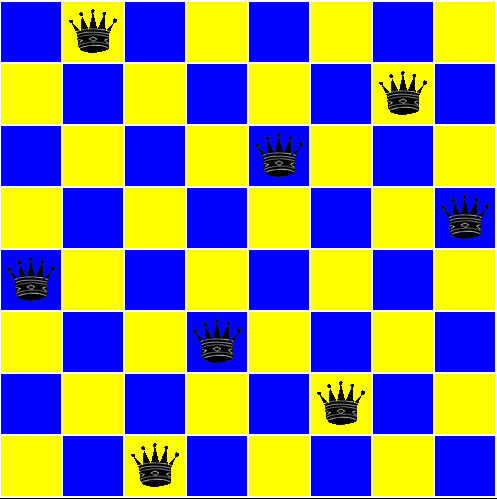